# Food Facts Project: Applied Data Analysis
Welcome to my 2nd project of __The EPFL Extension School course: Applied Machine Learning.__ Before being able to work with Machine Learning tools, we need to construct the milestones of Data Analysis with Python.
This project aims to demonstrate my ability to extract, tranform and prepare data, as well as making some basics analysis. Let's begin !

First of all, as the saying goes, a good worker works with the right tools. So let's import our libraries and the data we need:

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

## A. Data import and high level exploration
### Download

In [2]:
# Import data
data = pd.read_csv("../en.openfoodfacts.org.products.tsv", sep='\t')

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The first warning tells us that there are columns with different types. They have therefore been transformed into type object, the most general class. I'm not going to make any class changes now because with the deletion of some columns and rows, this could solve the problem, but it's important to keep this in mind.

In [3]:
# types of the mixed columns
data.iloc[:,[0,3,5,19,20,24,25,26,27,28,36,37,38,39,48]].dtypes

code                              object
created_t                         object
last_modified_t                   object
manufacturing_places              object
manufacturing_places_tags         object
emb_codes                         object
emb_codes_tags                    object
first_packaging_code_geo          object
cities                            object
cities_tags                       object
allergens_en                      object
traces                            object
traces_tags                       object
traces_en                         object
ingredients_from_palm_oil_tags    object
dtype: object

In [4]:
# dimension of the data
data.shape

(356027, 163)

We find the expected number of rows and columns, so we can assume that the import was done correctly.
### Exploratory data analysis
#### First Peek

Let's first of all peek at the data:

In [5]:
data.head(5).T

,0,1,2,3,4
code,3087,4530,4559,16087,16094
url,http://world-en.openfoodfacts.org/product/0000...,http://world-en.openfoodfacts.org/product/0000...,http://world-en.openfoodfacts.org/product/0000...,http://world-en.openfoodfacts.org/product/0000...,http://world-en.openfoodfacts.org/product/0000...
creator,openfoodfacts-contributors,usda-ndb-import,usda-ndb-import,usda-ndb-import,usda-ndb-import
created_t,1474103866,1489069957,1489069957,1489055731,1489055653
created_datetime,2016-09-17T09:17:46Z,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,2017-03-09T10:35:31Z,2017-03-09T10:34:13Z
last_modified_t,1474103893,1489069957,1489069957,1489055731,1489055653
last_modified_datetime,2016-09-17T09:18:13Z,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,2017-03-09T10:35:31Z,2017-03-09T10:34:13Z
product_name,Farine de blé noir,Banana Chips Sweetened (Whole),Peanuts,Organic Salted Nut Mix,Organic Polenta
generic_name,NaN,NaN,NaN,NaN,NaN
quantity,1kg,NaN,NaN,NaN,NaN


There seems to be some missing data in this dataset. Let's try to find the proportion of missing values per column.

#### Missing values

In [6]:
# Proportion of missing values
data.isnull().sum()/data.shape[0]*100

code                                      0.007303
url                                       0.007303
creator                                   0.000843
created_t                                 0.000843
created_datetime                          0.002809
last_modified_t                           0.000000
last_modified_datetime                    0.000000
product_name                              4.918728
generic_name                             83.789432
quantity                                 66.495519
packaging                                74.732534
packaging_tags                           74.732534
brands                                    8.159494
brands_tags                               8.165111
categories                               70.985627
categories_tags                          70.992369
categories_en                            70.985066
origins                                  92.964017
origins_tags                             92.974690
manufacturing_places           

We can observe that we have a lot of missing values in this data. Even some columns have no data (missing = 100%). How should we handle this? First of all, we can remove empty columns.

In [7]:
# Remove empty columns
data = data.dropna(how='all', axis=1)
data.shape

(356027, 147)

Then, I will mainly focus on products that contain some information on its nutriments. This information is contained in the variables with the _100g suffix. Hence, I will only keep the products where at least one of these columns contain some information. I will also delete any potential duplicates:

In [8]:
# looking at empty raws
composant = []
for s in data.columns:
    if '_100g' in s: composant.append(s)
data_subset_columns = data[composant]
print('empty _100g raws: {}'.format(data_subset_columns.isnull().all(axis=1).sum()))

# Deleting them
data = data[data_subset_columns.notnull().any(axis=1)]
data.shape

empty _100g raws: 55904


(300123, 147)

In [87]:
# Look if there are any duplicates
duplicate_test = data.set_index("code")
duplicate_test.loc[duplicate_test.duplicated(),:]

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,


For some columns, the proportion of missing values is enormous! (>90%). Unfortunately, some of these variables are unusable for machine learning. Especially for string variables where imputation is very difficult. We could however treat the missing numerical variables by putting the value of 0 which could be legitimate. Indeed, since we talk about the quantity of each nutrient, we could assume that a missing value correspond of 0 gram of that nutrient. It can be assumed that the label of a product only specifies the amount of nutrients present in the product. For example, we do not need to specify that a meat does not contain caffeine.

So, should we leave the missing numeric values or complete them with 0?

Missing values implies several issues. First, the absence of data reduces statistical power and can produce biased estimates, leading to invalid conclusions. Second, it can reduce the representativeness of the samples.

So, my first choice would be to complete the missing nutrient values with 0's. However some problems could arise. Filling missing values with 0's will definitely reduce the mean. It will also be more difficult to determine the outliers. So we should be careful when doing some analysis.

#### Columns Data Types
When we first downloaded the dataset, a warning appeared that some columns contained multiple types.

Let's have a look at it.

In [10]:
# Number of dtypes
data.get_dtype_counts() 

object     56
float64    91
dtype: int64

It seems that we have 2/3 of the variables that are numeric, and 1/3 that are non-numeric. We have to be careful though, because some of the variables contains multiple types and have been converted into object. I'm surprised that I don't see some __date type__ variables. Let's have a look at it.

In [11]:
data.created_datetime.dtype

dtype('O')

Here, it is typically a column where we will have to pay attention and transform it into __Date format__ in order to be able to better analyse the following.

#### Numerical variables: Descriptive statistics

Now let's have a look at the numerical variables:

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,272215.0,1.915089,2.510294e+00,0.000000,0.000000e+00,1.000000,3.000000,3.000000e+01
ingredients_from_palm_oil_n,272215.0,0.023445,1.531694e-01,0.000000,0.000000e+00,0.000000,0.000000,2.000000e+00
ingredients_that_may_be_from_palm_oil_n,272215.0,0.059479,2.789774e-01,0.000000,0.000000e+00,0.000000,0.000000,6.000000e+00
energy_100g,295367.0,1125.453320,9.368260e+02,0.000000,3.820000e+02,1092.000000,1674.000000,2.311990e+05
energy-from-fat_100g,869.0,587.216617,7.132557e+02,0.000000,4.940000e+01,300.000000,900.000000,3.830000e+03
fat_100g,279497.0,56065.871771,2.963385e+07,0.000000,1.000000e-01,5.290000,20.000000,1.566667e+10
saturated-fat_100g,263823.0,5.092460,7.965148e+00,0.000000,0.000000e+00,1.790000,7.140000,5.500000e+02
-caprylic-acid_100g,1.0,7.400000,NaN,7.400000,7.400000e+00,7.400000,7.400000,7.400000e+00
-capric-acid_100g,2.0,6.040000,2.262742e-01,5.880000,5.960000e+00,6.040000,6.120000,6.200000e+00
-lauric-acid_100g,4.0,36.136182,2.410143e+01,0.044730,3.466118e+01,47.600000,49.075000,4.930000e+01


There are three kinds of numerical values: 
- The column with suffix _n count the number of that element in the product.
- The columns with suffix _100g count the quantity of that element in 100 gramme of the product.
- The two columns _nutrition-score_ a nutritional rating system that follow its own logic. We have a categorized column for these values _"nutrition_grade_fr"_


First of all I noticed some negative values. Since we talk about the amount of a nutriment for 100g it should not be possible to have negative values.

In [13]:
# Select numerical values
num = data._get_numeric_data()
# Select columns that have negative values
num.columns[(num < 0).any()].tolist()

['trans-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'pantothenic-acid_100g',
 'silica_100g',
 'iron_100g',
 'copper_100g',
 'selenium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

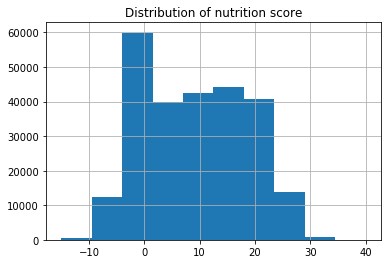

In [14]:
# Plot nutrition-score-fr_100g histogram
data['nutrition-score-uk_100g'].hist()
plt.title("Distribution of nutrition score")
plt.show()

For the last two columns (Nutrition-score), it is ok, as we saw above. But for the other, we would have to clean these data. Let's now look at the other extremes values or outliers.

In [15]:
# Create a dataframe with the 75% percentile and the max of each column
outliers = pd.DataFrame(data.describe().T['75%'],columns = ['75%'])
outliers['max']=data.describe().T['max']
# drop missing values
outliers.dropna()
print("Number of columns where the maximum value is more than 10 times the 75% percentile: {}".format(sum(outliers['75%']*10 < outliers['max'])))

Number of columns where the maximum value is more than 10 times the 75% percentile: 52


A lot of numerical variables have outliers. Another thing that I wonder is that normally, a column with a _100g suffix shouldn't have a value above 100, since we cannot have a quantity that is more than 100g for one nutrient.

In [16]:
outliers_column = outliers[outliers['max'] > 100].T.columns
outliers[outliers['max'] > 100]

,75%,max
energy_100g,1674.000000,2.311990e+05
energy-from-fat_100g,900.000000,3.830000e+03
fat_100g,20.000000,1.566667e+10
saturated-fat_100g,7.140000,5.500000e+02
omega-3-fat_100g,3.300000,2.060000e+02
omega-6-fat_100g,24.150000,4.130000e+02
-linoleic-acid_100g,3.719000,1.400000e+03
trans-fat_100g,0.000000,3.690000e+02
carbohydrates_100g,57.580000,1.566667e+10
sugars_100g,23.330000,3.520000e+03


Apart from the energy which is calculated in joules, the other variables should not be above 100g. Let's try to graph a boxplot of the most important ones. 

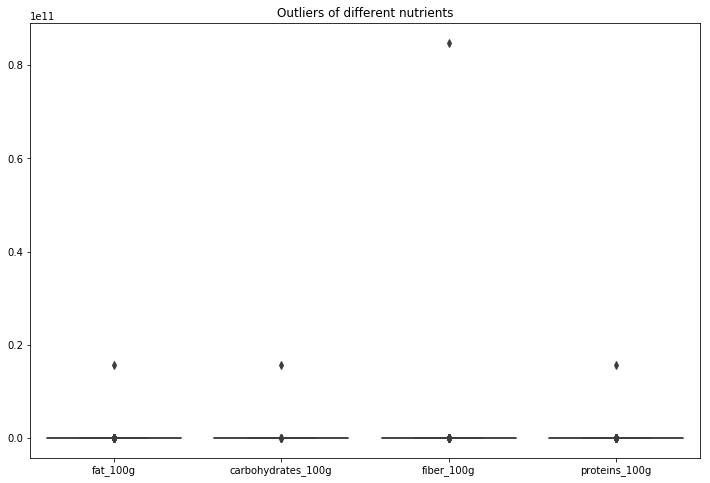

In [17]:
fig, ax = plt.subplots(figsize= (12, 8))
sns.boxplot(data=data[['fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g']]).set_title("Outliers of different nutrients");

We clearly see some unplausible values. We will have to clean this data properly when dealing with theses categories.

####  Redundant variables¶
Various variables in this dataframe contain redundant informations: this is for example the case for the variables existing with _t, or _datetime.

In [18]:
# Compare variables with suffix _t and _datetime
data.loc[:,data.columns.str.endswith(('_t', '_datetime'))].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
1,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z
2,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z
3,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z
4,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z
5,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z


The \__t variables_ are just dates in the UNIX timestamp format (number of seconds since Jan 1st 1970). Let's have a look at other categorical variables.

In [19]:
# Select non-numeric data
data.select_dtypes(exclude = np.number).T[356005]

code                                                                              9847548283004
url                                           http://world-en.openfoodfacts.org/product/9847...
creator                                                                               drmalabar
created_t                                                                            1437817626
created_datetime                                                           2015-07-25T09:47:06Z
last_modified_t                                                                      1442237848
last_modified_datetime                                                     2015-09-14T13:37:28Z
product_name                                                Tartines craquantes bio au sarrasin
generic_name                                                                                NaN
quantity                                                                                    NaN
packaging                               

- fields that end with _tags are lists of comma-separated replicates of the original column name.
- there are several urls column with the suffix _url
- the columns with the suffix _en are the english version of the original column name
- finally, the first column (code) is simply barcode of the product.

What we can learn from this is that there are lots of redundant variables, and we can filter according to what we are interested in to do our research.

Finally, I would like to see what are the top values for certain categorical variables.

In [37]:
categorical_variables = data.select_dtypes(exclude = np.number)
# top 10 brands
top_10_brands = categorical_variables['brands'].value_counts()[:10]
top_10_brands

Carrefour       3243
Auchan          2890
U               2375
Meijer          1995
Casino          1864
Leader Price    1775
Kroger          1660
Ahold           1370
Spartan         1341
Roundy's        1299
Name: brands, dtype: int64

In [34]:
# top 10 categories
top_10_categories = categorical_variables['categories'].value_counts()[:10]
top_10_categories

en:beverages                                                       2368
en:fats                                                             715
Ketchup                                                             363
en:milks                                                            311
Snacks sucrés,Chocolats,Chocolats noirs                             292
Snacks sucrés,Biscuits et gâteaux,Biscuits                          290
Biscuits                                                            258
en:non-sugared-beverages, en:beverages                              247
Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat     237
popcorn                                                             205
Name: categories, dtype: int64

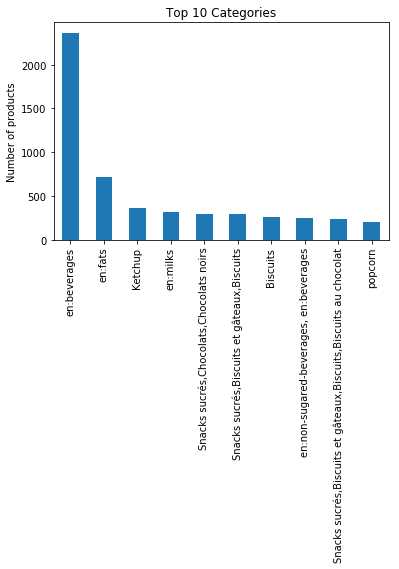

In [35]:
top_10_categories.plot(kind='bar')
plt.title("Top 10 Categories")
plt.ylabel("Number of products");

In [31]:
# top 10 countries
top_10_countries =categorical_variables['countries_en'].value_counts()[:10]
top_10_countries

United States         171743
France                 94939
Switzerland            10880
Germany                 5444
Spain                   3215
United Kingdom          1906
France,Switzerland      1409
Russia                  1051
Belgium                  769
Belgium,France           684
Name: countries_en, dtype: int64

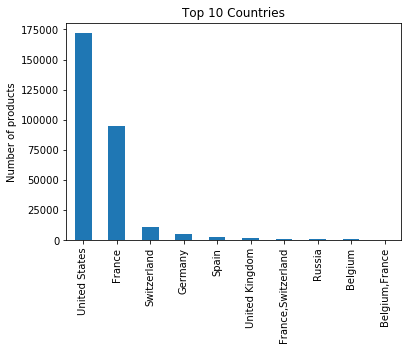

In [33]:
top_10_countries.plot(kind='bar')
plt.title("Top 10 Countries")
plt.ylabel("Number of products");

In [28]:
# top 10 labels
top_ten_labels = categorical_variables['labels_en'].value_counts()[:10]
top_ten_labels

Organic                                                      4934
Organic,EU Organic,fr:AB Agriculture Biologique              4690
Green Dot                                                    3318
Vegetarian,Vegan                                             1180
Green Dot,fr:Eco-emballages                                   730
Organic,EU Organic,FR-BIO-01,fr:AB Agriculture Biologique     678
Gluten-free                                                   484
Labels of distributors,fr:Sélection Intermarché               453
Vegetarian                                                    427
PDO                                                           417
Name: labels_en, dtype: int64

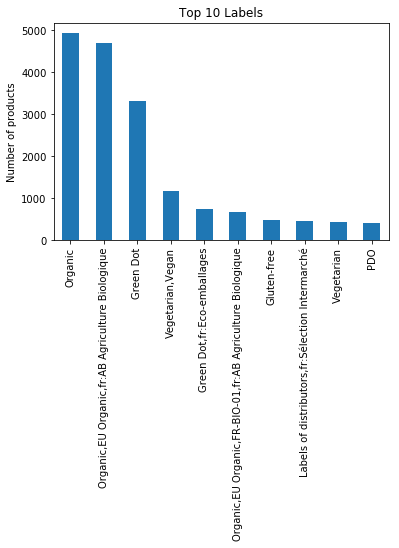

In [30]:
top_ten_labels.plot(kind='bar')
plt.title("Top 10 Labels")
plt.ylabel("Number of products");

## B. In-depth analysis
Now that we have analysed the data, we have a good intuition of what it contains. We can therefore try to answer 3 questions that interest us. I know I'm supposed to come up with my own questions, but I'm really interested in the ones that are proposed. Also, the topic I thought about were "which nutrient is most correlated with the nutrition score" which is a question that will be dealt with in point F. I had also thought about Vegan products and carbon-footprint, but unfortunately, there is little data related to that. I think it is a pity to remove 90% of our data to make our analysis. So, I will continue with these three questions that seem relevant and have enough data to be analysed:

- Are products number of additives correlated with their nutrition scores?
- Are there countries with more or less risky additives?
- What product category is most prone to having many additives?

First of all, I need to do a subset of the data. I need to select the columns desired. The variables that I need are the __categories_en__ (list of categories), __additives_n__ (the number of additives), __additives_en__ (list of additive names), __the nutrition-score__ (UK, since we speak in english), and the __countries_en__.

### Cleaning data

In [41]:
# Select the columns needed
data_sub = data[["product_name","categories_en", "additives_n","additives_en", "nutrition-score-uk_100g",
                 "countries_en"]].copy()
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300123 entries, 1 to 356026
Data columns (total 6 columns):
product_name               296616 non-null object
categories_en              85498 non-null object
additives_n                272215 non-null float64
additives_en               166529 non-null object
nutrition-score-uk_100g    254856 non-null float64
countries_en               300048 non-null object
dtypes: float64(2), object(4)
memory usage: 16.0+ MB


Lets look again at the missing values:

In [42]:
# Proportion of missing values
data_sub.isnull().sum()/data_sub.shape[0]*100

product_name                1.168521
categories_en              71.512347
additives_n                 9.298854
additives_en               44.513083
nutrition-score-uk_100g    15.082816
countries_en                0.024990
dtype: float64

In [43]:
data_sub.head()

,product_name,categories_en,additives_n,additives_en,nutrition-score-uk_100g,countries_en
1,Banana Chips Sweetened (Whole),NaN,0.0,NaN,14.0,United States
2,Peanuts,NaN,0.0,NaN,0.0,United States
3,Organic Salted Nut Mix,NaN,0.0,NaN,12.0,United States
4,Organic Polenta,NaN,0.0,NaN,NaN,United States
5,Breadshop Honey Gone Nuts Granola,NaN,0.0,NaN,NaN,United States


The two categories with the most missing values are _categories_en_ and _additives_en. Since we can answer most of our questions without the categories_en variable, I will simply fill the na values with the text "no-category". When we look at the _additives_en_ more closely, we notice that the NaN values are in fact when we don't have any additives in the product. I will also fill them with the text "none".

In [44]:
# Filling NA of categorical variables
data_sub['categories_en'] = data_sub['categories_en'].fillna(value='No Category')

In [45]:
data_sub['additives_en'] = data_sub['additives_en'].fillna(value= 'None')

Next we have the nutrition_score with around 15% of missing values. We could try to use machine learning to impute so values based on the nutriments, unfortunately for the moment I am not able to do that. I could also impute the missing values with the mean, the median or the last value. But I think that none of these methods are smart. As we still have a lot of data, I think I can afford to delete the missing data. Let's do the same for the other variables as we don't have many missing values.

In [46]:
# drop missing data in the column nutrition-score-uk
data_sub = data_sub.dropna(axis = 0)
data_sub.shape

(228829, 6)

In [47]:
data_sub.isnull().sum()/data_sub.shape[0]*100

product_name               0.0
categories_en              0.0
additives_n                0.0
additives_en               0.0
nutrition-score-uk_100g    0.0
countries_en               0.0
dtype: float64

Well, we have now some clean data with no missing values. We can start to look for our research questions.

### Question 1: Are products number of additives correlated with their nutrition scores?
My first assumption would be to say that the more additives the product has, the higher the nutrition scores is. We need to know that a negative score represent the Letter "A" which is really good, whereas a high score such as 20 or above represent the letter "E" which is not good. Let's try to check their correlation.

In [48]:
# checking the data types
data_sub.dtypes

product_name                object
categories_en               object
additives_n                float64
additives_en                object
nutrition-score-uk_100g    float64
countries_en                object
dtype: object

In [49]:
# Check the correlation
np.corrcoef(data_sub['nutrition-score-uk_100g'],data_sub.additives_n)

array([[1.        , 0.16388422],
       [0.16388422, 1.        ]])

So the correlation is ~.16 which is very low. Let's represent it graphically to better understand the data

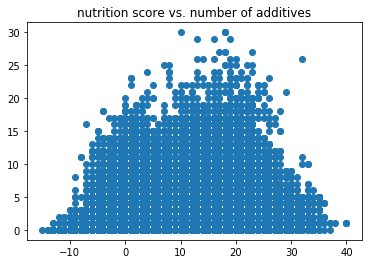

In [50]:
plt.scatter(data_sub['nutrition-score-uk_100g'],data_sub.additives_n)
plt.title("nutrition score vs. number of additives");

On our first findings, we cannot assume any relationship between these two categories. One reason I could imagine is that not all the additives are bad. We could maybe try to select only the additives that are dangerous. For that, I need to download a list of these additives with their relative dangerousness.

In [51]:
# Get the data form HTML page
additives_list = pd.read_html('https://world.openfoodfacts.org/additives')
additives_list = additives_list[0]
print(additives_list.head())

                   Additive  Products   * Risk
0        E330 - Citric acid    135701 NaN  NaN
1          E322 - Lecithins     91246 NaN  NaN
2          E322i - Lecithin     82827 NaN  NaN
3  E500 - Sodium carbonates     57758 NaN  NaN
4        E415 - Xanthan gum     51229 NaN  NaN


Now that we have our list, let's find and select the dangerous ones.

In [52]:
additives_list.Risk.unique()

array([nan, 'High risk of over exposure',
       'No or very low risk of over exposure',
       'Moderate risk of over exposure'], dtype=object)

In [53]:
# Create a list of dangerous additives
risky_additives = list(additives_list[additives_list.Risk == "High risk of over exposure"]['Additive'])
risky_additives[:5]

['E202 - Potassium sorbate',
 'E450 - Diphosphates',
 'E407 - Carrageenan',
 'E250 - Sodium nitrite',
 'E341 - Calcium phosphates']

Now that we have our list, let's see how are the names presented in our original data.

In [54]:
# First 5 unique values of data
data_sub.additives_en.unique().tolist()[:5]

['None',
 'E307c - Tocopherol',
 'E322 - Lecithins,E322i - Lecithin',
 'E330 - Citric acid,E339 - Sodium phosphates',
 'E170 - Calcium carbonate,E322 - Lecithins,E322i - Lecithin,E410 - Locust bean gum']

It appears that some string (products) have several additives. We need to look for a way to detect if the string contains any of the additives in the previous extracted list. That is, we need to test if a string contains any of the substring in a list.

In [55]:
# select the rows, where the string contains any of the risky additive in the list
risky_products = data_sub[data_sub.additives_en.str.contains('|'.join(risky_additives))]

Now we can plot them again:

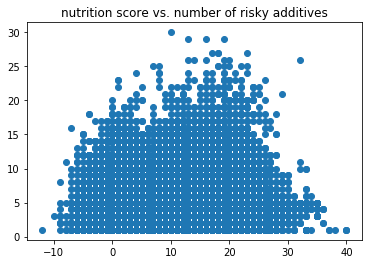

In [56]:
plt.scatter(risky_products['nutrition-score-uk_100g'],risky_products.additives_n)
plt.title("nutrition score vs. number of risky additives");

In [57]:
np.corrcoef(risky_products['nutrition-score-uk_100g'],risky_products.additives_n)

array([[1.        , 0.03970185],
       [0.03970185, 1.        ]])

The correlation is even worse! So we can definitely conclude that there is no relationship between the nutrition score and the number of additives. A plausible explanation is that __the nutrition score don't take into account the additives in their calculation.__

### Question 2: Are there countries with more or less risky additives?
We already have the list. let's try to plot it over the countries. But first of all, we can already delete the data that don't contain any additives. 

In [58]:
data_additives = data_sub[data_sub.additives_en != "None"].copy()
data_additives.shape

(141336, 6)

#### Cleaning Country names
Now we can take a look at the countries variable. 

In [59]:
data_additives.countries_en.unique()[:10]

array(['United States', 'Canada', 'France', 'Germany', 'United Kingdom',
       'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Belgium,France',
       'Mexico', 'France,Iraq'], dtype=object)

So we see, that sometimes, there is a list of all the countries this product are in. In order to be able to calculate the number of products with additives per country, we need to have one row per product __and__ per country. We need first to put all this data into lists and then create a row per list element. 

In [60]:
# Creat lists of countries, of which each element is a country
data_additives.countries_en = data_additives.countries_en.str.split(",")
# Unstack the data to have one row per country
countries = data_additives.set_index(["product_name",'additives_en'])['countries_en'].apply(pd.Series).stack()
# reset the original index
countries = countries.reset_index()
# delete superflues columns
countries = countries.drop("level_2", axis=1)
# rename column names
countries.columns = ['product_name','additives_en','countries_en']

we now have one row per country and per product. Let's look at the unique values that we have.

In [61]:
countries.countries_en.unique()

array(['United States', 'Canada', 'France', 'Germany', 'United Kingdom',
       'Belgium', 'Netherlands', 'Mexico', 'Iraq', 'Australia', 'Sweden',
       'Switzerland', 'New Zealand', 'Singapore', 'Thailand',
       'French Polynesia', 'Spain', 'Scotland', 'Italy', 'Cuba', 'China',
       'Saint Pierre and Miquelon', 'fr:Quebec', 'Czech Republic',
       'Indonesia', 'Serbia', 'French Guiana', 'fr:Angleterre',
       'fr:Grande-bretagne', 'Hong Kong', 'Lebanon', 'Japan', 'Morocco',
       'Philippines', 'Portugal', 'Ireland', 'Lithuania', 'Senegal',
       'Réunion', 'South Korea', 'Hungary', 'Romania', 'Iceland', 'World',
       'Turkey', 'Chile', 'fr:Deutschland', 'fr:Frankreich',
       'European Union', 'Luxembourg', 'Slovenia', 'Austria', 'Denmark',
       'fr:Spanien', 'Greece', 'New Caledonia', 'Argentina', 'Colombia',
       'Russia', 'Saudi Arabia', 'South Africa', 'Algeria', 'Mali',
       'Martinique', 'Guadeloupe', 'fr:Marseille-5', 'Gabon', 'Mayotte',
       'Tunisia', 'Ku

We need to clean the names a bit. First, we will make some text cleaning to have homogenous names, by deleting any prefix. Then we will replace the names that are in another language (e.g. french, german) into their english equivalent. Finally we will remove the names that are not in the latin alphabet. Let's begin by defining a transform function.

In [62]:
# Create a function to transform the names of the countries
def transform(s):
    s = s.str.replace("fr:", "")                   # remove prefix
    s = s.str.replace("nl:", "")
    s = s.str.replace("xx:", "")
    s = s.str.replace("Quebec", "Canada")         # replace by the english country names
    s = s.str.replace("Angleterre", "United Kingdom")
    s = s.str.replace("Grande-bretagne", "United Kingdom")
    s = s.str.replace("Spanien", "Spain")
    s = s.str.replace("Deutschland", "Germany")
    s = s.str.replace("Frankreich", "France")
    s = s.str.replace("Marseille-5", "France")
    s = s.str.replace("Alemania", "Germany")
    s = s.str.replace("Reino-unido", "United Kingdom")
    s = s.str.replace("Bourgogne-aube-nogent-sur-seine", "France")
    s = s.str.replace("Puyricard", "France")
    s = s.str.replace("Frankrijk", "France")
    s = s.str.replace("Griekenland", "Greece")
    s = s.str.replace("Spanje", "Spain")
    s = s.str.replace("Schweiz", "Switzerland")
    s = s.str.replace("Nederland", "Netherlands")
    s = s.str.replace("Irland", "Ireland")
    s = s.str.replace("Belgiqu", "Belgium")
    s = s.str.replace("Belgien", "Belgium")
    s = s.str.replace("Danemark", "Denmark")
    s = s.str.replace("Saint Pierre and Miquelon", "France")
    s = s.str.replace("Hong Kong", "China")
    s = s.str.replace("Allemagne", "Germany")
    s = s.str.replace("Szczecin", "Czech Republic")
    s = s.str.replace("Other-turquie", "Turkey")
    return(s)

# transform the countries names
countries.countries_en = transform(countries.countries_en)
countries.countries_en.unique()

array(['United States', 'Canada', 'France', 'Germany', 'United Kingdom',
       'Belgium', 'Netherlands', 'Mexico', 'Iraq', 'Australia', 'Sweden',
       'Switzerland', 'New Zealand', 'Singapore', 'Thailand',
       'French Polynesia', 'Spain', 'Scotland', 'Italy', 'Cuba', 'China',
       'Czech Republic', 'Indonesia', 'Serbia', 'French Guiana',
       'Lebanon', 'Japan', 'Morocco', 'Philippines', 'Portugal',
       'Ireland', 'Lithuania', 'Senegal', 'Réunion', 'South Korea',
       'Hungary', 'Romania', 'Iceland', 'World', 'Turkey', 'Chile',
       'European Union', 'Luxembourg', 'Slovenia', 'Austria', 'Denmark',
       'Greece', 'New Caledonia', 'Argentina', 'Colombia', 'Russia',
       'Saudi Arabia', 'South Africa', 'Algeria', 'Mali', 'Martinique',
       'Guadeloupe', 'Gabon', 'Mayotte', 'Tunisia', 'Kuwait', 'Monaco',
       'Vanuatu', 'Poland', "Côte d'Ivoire", 'United Arab Emirates',
       'Madagascar', 'Croatia', 'India', 'Finland', 'Norway',
       'Montenegro', 'Ukraine', 'E

That is way better. We still have some weird names. Let's remove any country that contains non-latin alphabet.

In [63]:
# remove non-latin country names
countries.countries_en = countries.countries_en[countries.countries_en.str.contains("[^a-zA-Z ]+") == False]
countries.countries_en.unique()

array(['United States', 'Canada', 'France', 'Germany', 'United Kingdom',
       'Belgium', 'Netherlands', 'Mexico', 'Iraq', 'Australia', 'Sweden',
       'Switzerland', 'New Zealand', 'Singapore', 'Thailand',
       'French Polynesia', 'Spain', 'Scotland', 'Italy', 'Cuba', 'China',
       'Czech Republic', 'Indonesia', 'Serbia', 'French Guiana',
       'Lebanon', 'Japan', 'Morocco', 'Philippines', 'Portugal',
       'Ireland', 'Lithuania', 'Senegal', nan, 'South Korea', 'Hungary',
       'Romania', 'Iceland', 'World', 'Turkey', 'Chile', 'European Union',
       'Luxembourg', 'Slovenia', 'Austria', 'Denmark', 'Greece',
       'New Caledonia', 'Argentina', 'Colombia', 'Russia', 'Saudi Arabia',
       'South Africa', 'Algeria', 'Mali', 'Martinique', 'Guadeloupe',
       'Gabon', 'Mayotte', 'Tunisia', 'Kuwait', 'Monaco', 'Vanuatu',
       'Poland', 'United Arab Emirates', 'Madagascar', 'Croatia', 'India',
       'Finland', 'Norway', 'Montenegro', 'Ukraine', 'Egypt', 'Qatar',
       'Taiwan

Fiou, that was a big piece but we finally made it. Now that we have the correct names, I will try to create a category for the dangerousness. First, lets create two other list for the moderate and low risk additives

In [64]:
# Create the two other additives list
medium_risk_additives = list(additives_list[additives_list.Risk == "Moderate risk of over exposure"]['Additive'])
low_risk_additives = list(additives_list[additives_list.Risk == "No or very low risk of over exposure"]['Additive'])

Now, we will create a new column _risk_ based on the results of these list. If the product contains at least one High risk additive, it is considered as High risk. If not, if it contains at least a moderate risk additive, it is moderate, and if it contains only low risk additives, it is considered as "low". We remove any additives which we don't have infos on. 

In [65]:
# Create Risk Category
countries.loc[countries.additives_en.str.contains('|'.join(low_risk_additives)), "risk"] = "Low"
countries.loc[countries.additives_en.str.contains('|'.join(medium_risk_additives)), "risk"] = "Medium"
countries.loc[countries.additives_en.str.contains('|'.join(risky_additives)), "risk"] = "High"
countries.dropna(inplace = True)
countries.head()

,product_name,additives_en,countries_en,risk
2,Fire Roasted Hatch Green Chile Almonds,"E330 - Citric acid,E339 - Sodium phosphates",United States,High
7,10-Grain Pancake Mix,"E339 - Sodium phosphates,E341 - Calcium phosph...",United States,High
14,Turkish Apricots,E220 - Sulphur dioxide,United States,High
17,Chaussons tressés aux pommes,"E202 - Potassium sorbate,E211 - Sodium benzoat...",Canada,High
18,Root Beer,"E150 - Caramel,E211 - Sodium benzoate,E999 - Q...",France,High


Voilà, we can finally try to make some plots. Let's choose the most representative countries of our data

In [66]:
# Count the number of rows per Country
countries_total = countries.groupby("countries_en").count().sort_values(["risk"], ascending= False)[:6]['risk']
countries_total.name = "total"
countries_total

countries_en
United States     41531
France            20142
Switzerland        1583
Spain               697
Germany             679
United Kingdom      439
Name: total, dtype: int64

The United States and France are overrepresented. Maybe they are more precise in labeling their food products. Lets make some plot of the results for these 6 countries.

In [67]:
# Create list of desired countries
country_list = ["United States", "France", "Switzerland", "Spain", "Germany", "United Kingdom"]
# subseting these countries
countries_graph = countries[countries['countries_en'].isin(country_list)]

# Count number of values per country / Here I use some manipulation instead of the size() function 
# in order to be able to plot the data as I want.
countries_count = countries_graph.groupby(['countries_en', 'risk']).count().sort_values(['product_name'], ascending = False)
countries_count.reset_index(inplace=True)
countries_count.drop("additives_en", axis=1, inplace = True)
countries_count = countries_count.rename(columns={"product_name":"n_additives"})
countries_count

,countries_en,risk,n_additives
0,United States,High,30454
1,France,High,17665
2,United States,Medium,6538
3,United States,Low,4539
4,France,Medium,1521
5,Switzerland,High,1363
6,France,Low,956
7,Spain,High,595
8,Germany,High,558
9,United Kingdom,High,372


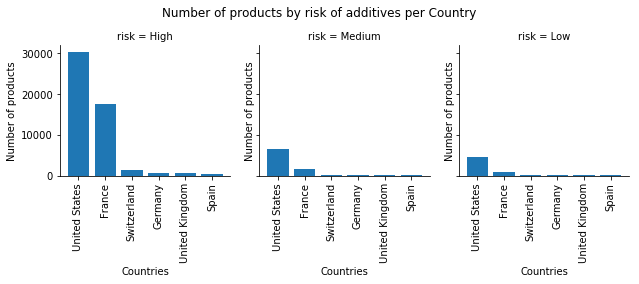

In [68]:
# Plot the graphs

# create the grid and map the variables to the grid
grid = sns.FacetGrid(countries_count, col='risk')
grid = grid.map(plt.bar, "countries_en", "n_additives")

# rotate x labels
for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
grid.set(xlabel='Countries', ylabel='Number of products')

#add overall title
grid.fig.suptitle('Number of products by risk of additives per Country')

#move overall title up
grid.fig.subplots_adjust(top=.8);

The United States seem to have the most products with high risk. But they also have the most products with medium and low risk additives. Let's try see the proportion of it.

In [69]:
# Joining the two files with the total
countries_prop = pd.merge(countries_count, countries_total, how='left', on = "countries_en")
# adding a proportion column
countries_prop["%"] = countries_prop.n_additives / countries_prop.total * 100
# sort the table
countries_prop = countries_prop.sort_values("%", ascending = False)
countries_prop

,countries_en,risk,n_additives,total,%
1,France,High,17665,20142,87.702314
5,Switzerland,High,1363,1583,86.102337
7,Spain,High,595,697,85.365854
9,United Kingdom,High,372,439,84.738041
8,Germany,High,558,679,82.179676
0,United States,High,30454,41531,73.328357
2,United States,Medium,6538,41531,15.742457
12,Spain,Medium,77,697,11.047346
3,United States,Low,4539,41531,10.929185
13,Germany,Medium,69,679,10.162003


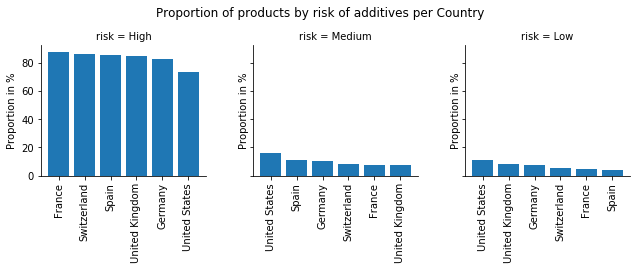

In [70]:
# Plot the graphs
grid = sns.FacetGrid(countries_prop, col='risk', sharex=False)
grid = grid.map(plt.bar, "countries_en", "%")

# Rotate the x labels
for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        
grid.set(xlabel='', ylabel='Proportion in %')

#add overall title
grid.fig.suptitle('Proportion of products by risk of additives per Country')

#move overall title up
grid.fig.subplots_adjust(top=.8);

When we look in terms of proportion, it is rather France that has the most risky products. Of course, one must always bear in mind that everything depends on the quality of the data. Are they all well written? Here, France and the United States seem to have the majority of products.

### Question 3: What product category is most prone to having many additives?
The data in the category column is similar to the one with country, they have several categories for one product. So we will firstly create one column per category and per product.

In [71]:
# removing products with no category
data_category = data_sub.loc[data_sub.categories_en != "No Category", ["product_name", "categories_en","additives_n"]]
# convert type into string
data_category.categories_en = data_category.categories_en.astype(str) 

In [72]:
# Creat lists of countries, of which each element is a country
data_category.categories_en = data_category.categories_en.str.split(",")
# Unstack the data to have one row per country
categories = data_category.set_index(["product_name",'additives_n'])['categories_en'].apply(pd.Series).stack()
# reset the original index
categories = categories.reset_index()
# delete superflues columns
categories = categories.drop("level_2", axis=1)
# rename column names
categories.columns = ['product_name','additives_n','categories_en']

Then I will remove the products in other languages and look at the most used categories.

In [73]:
# Remove categories name in other languages
categories.categories_en = categories.categories_en[categories.categories_en.str.contains(":") == False]

categories.groupby("categories_en").count().sort_values("additives_n", ascending = False).head(30)['product_name']

categories_en
Plant-based foods and beverages      20226
Plant-based foods                    17382
Sugary snacks                        10389
Beverages                             8355
Dairies                               8072
Cereals and potatoes                  7039
Meals                                 6665
Fruits and vegetables based foods     5565
Cereals and their products            5216
Desserts                              4944
Biscuits and cakes                    4435
Non-sugared beverages                 4204
Meats                                 4195
Fresh foods                           3972
Canned foods                          3736
Groceries                             3514
Spreads                               3508
Frozen foods                          3454
Plant-based beverages                 3454
Breakfasts                            3345
Cheeses                               3231
Sauces                                2941
Chocolates                            29

Ok, from these categories, I will choose several ones that make sense to me, and then compare them with the average number of additives.

In [74]:
# Create list of category names
category_names = ["Vegetables based foods", "Fruits based foods", "Salty snacks", "Sugary snacks", "Cereals and potatoes",
                  "Meats", "Frozen foods", "Beverages"]
# Filter the categories desired
categories = categories[categories.categories_en.isin(category_names)]

In [75]:
# Average number of additives per category
categories.groupby("categories_en").mean().sort_values("additives_n", ascending = False).head(10)

,additives_n
categories_en,
Sugary snacks,3.162576
Meats,2.507747
Frozen foods,2.419803
Salty snacks,1.667759
Beverages,1.464393
Cereals and potatoes,1.126865
Fruits based foods,1.088281
Vegetables based foods,0.470634


Not surprisingly, the sugary snacks are the category that contains on average the most additives (\~3) whereas the vegetables don't have many. However, I'm a bit surprised that meats also contains lots of additives on average (\~2.5).

## C. Text data
The goal here is to find the 5 most common ingredients from the _ingredients_text_ column.
To do this, we will first have to clean it.

In [76]:
ingredients = data["ingredients_text"]
ingredients.head(20)

1     Bananas, vegetable oil (coconut oil, corn oil ...
2     Peanuts, wheat flour, sugar, rice flour, tapio...
3     Organic hazelnuts, organic cashews, organic wa...
4                                       Organic polenta
5     Rolled oats, grape concentrate, expeller press...
6                         Organic long grain white rice
7     Org oats, org hemp granola (org oats, evaporat...
8     Organic chocolate liquor, organic raw cane sug...
9     Organic expeller pressed, refined high oleic s...
10                                 Organic adzuki beans
11           Organic refined durum semolina wheat flour
12    Roasted peanuts (peanuts, peanut or canola oil...
13                            Organic golden flax seeds
14    Organic dry roasted pumpkin seeds, tamari (soy...
15    Organic rolled oats, honey, raisins, almonds, ...
16                               Organic raw hazelnuts.
17    Organic bananas, organic coconut oil, organic ...
18                           Organic brown jasmi

We can already spot some specificities. Let's create a function that will insert a "," each time we have another article. We will then use this comma to separate each ingredient.

In [77]:
# define the separate function
def separate(s):
    s = s.str.replace("(", ",")
    s = s.str.replace(")", ",")
    s = s.str.replace("and/or", ",")
    s = s.str.replace("[", ",")
    s = s.str.replace("]", ",")
    s = s.str.replace("and ", ",")
    s = s.str.replace("or ", ",")
    return(s)

In [78]:
ingredients = separate(ingredients)
# Expand the data to have one element per cell and then stack them together
ingredients = ingredients.str.split(",", expand = True).stack()
ingredients = ingredients.reset_index(drop = True)

In [79]:
ingredients.head(10)

0                    Bananas
1             vegetable oil 
2                coconut oil
3                  corn oil 
4                   palm oil
5                      sugar
6     natural banana flavor.
7                    Peanuts
8                wheat flour
9                      sugar
dtype: object

Perfect, Now that we have one element per row, let's do some cleaning:

In [80]:
def clean (s):
    s = s.str.lower()
    s = s.str.replace("org ", "")
    s = s.str.replace("organic ", "")
    s = s.str.replace(".","")
    s = s.str.replace("[.*?]", "")
    s = s.str.replace("{.*?}", "")
    s = s.str.replace("\d", "")
    s = s.str.replace("%", "")
    s = s.str.replace("sel", "salt")
    s = s.str.replace("sucre", "sugar")
    s = s.str.replace("eau", "water")
    s = s.str.strip() # remove white space
    s = [string for string in s if string != ""] # remove empty string
    return(s)

cleaned_ingredients = clean(ingredients)

In [81]:
cleaned_ingredients[:10]

['bananas',
 'vegetable oil',
 'coconut oil',
 'corn oil',
 'palm oil',
 'sugar',
 'natural banana flavor',
 'peanuts',
 'wheat flour',
 'sugar']

That seems already better. Of course, we could spend a lot more time to clean these data (by treating the name in french, looking for meaningless ingredients), but we already have quite good data as it is. So let's find the top 10.

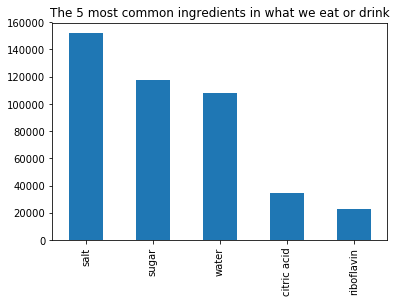

In [82]:
pd.Series(cleaned_ingredients).value_counts()[:5].plot(kind='bar')
plt.title("The 5 most common ingredients in what we eat or drink");

The first three ingredients were expected. Salt, sugar and water are found in almost all food products. What shocks me more are the chemical ingredients that take the 4th and 5th place. Citric acid is, as the name suggests, found in abundance in lemons, but is also used as a flavor enhancer. Riboflavin is better known as vitamin B2.

## D. Time-series analysis

Here, we will test our abilities to work with time series data by looking at the creation and last modified columns of our data
### Mean Difference

In [88]:
# Select columns
datetime = data[["created_datetime", "last_modified_datetime"]]
datetime.tail()

,created_datetime,last_modified_datetime
356010,2017-04-01T20:52:18Z,2017-04-01T20:52:19Z
356015,2013-07-10T18:20:08Z,2016-01-03T20:00:15Z
356017,2013-04-28T15:30:39Z,2013-06-20T01:09:16Z
356022,2017-03-09T11:31:16Z,2017-04-03T18:34:59Z
356026,2017-03-09T15:18:29Z,2017-04-03T18:34:59Z


In [89]:
# Select only data that match our expectation
datetime = datetime.dropna()
datetime = datetime[datetime.created_datetime.str.match("\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z")]
datetime = datetime[datetime.last_modified_datetime.str.match("\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z")]
# transform into datetime object
datetime = datetime.apply(pd.to_datetime)
datetime.dtypes

created_datetime          datetime64[ns, UTC]
last_modified_datetime    datetime64[ns, UTC]
dtype: object

In [90]:
# Create a column of the difference between the two columns
datetime["difference"] = datetime.last_modified_datetime - datetime.created_datetime
datetime.head()

,created_datetime,last_modified_datetime,difference
1,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,0 days
2,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,0 days
3,2017-03-09 10:35:31+00:00,2017-03-09 10:35:31+00:00,0 days
4,2017-03-09 10:34:13+00:00,2017-03-09 10:34:13+00:00,0 days
5,2017-03-09 10:34:11+00:00,2017-03-09 10:34:11+00:00,0 days


In [91]:
# Calculate the average difference
datetime.difference.mean()

Timedelta('106 days 07:17:49.643174')

We have an average of 106 days and a bit more than 7 hours.
### Total number of items created each month

For this question, we are first going to extract the month and year of each item into a new column.

In [92]:
#Create column year_month
datetime["year_month"] = datetime.created_datetime.dt.to_period('M')
# set it as index
datetime.set_index("year_month", inplace = True)
datetime = datetime.sort_index() # Make sure that the entries are sorted

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


In [93]:
# Counting the number of products created by month
datetime_count = datetime.groupby(datetime.index).size()
datetime_count.head(5)

year_month
2012-01      1
2012-02     11
2012-03    136
2012-04    172
2012-05    390
Freq: M, dtype: int64

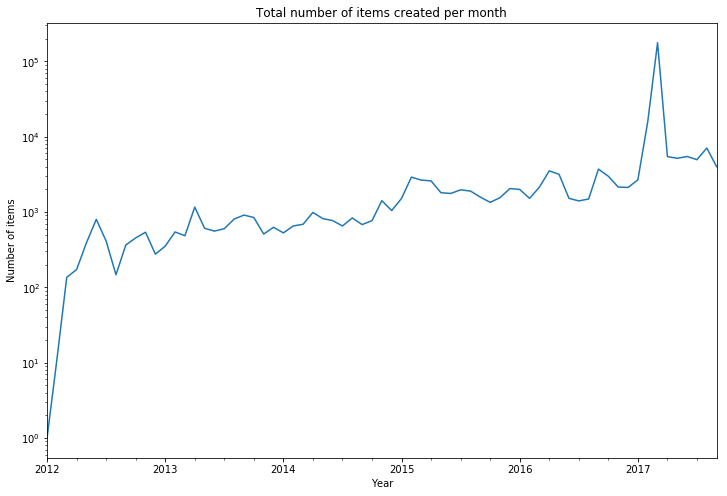

In [97]:
# Plot the graph
fig=plt.figure(figsize=(12,8))
datetime_count.plot(logy=True)
plt.title("Total number of items created per month")
plt.xlabel("Year")
plt.ylabel("Number of items");

It seems that most of the items where created in 2017. Let's zoom in this period.

In [95]:
# Select period
datetime_2016_2018 = datetime_count["2017-01":"2017-12"]

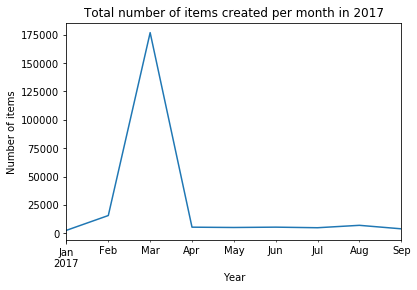

In [99]:
# Plot the new graph
datetime_2016_2018.plot()
plt.title("Total number of items created per month in 2017")
plt.xlabel("Year")
plt.ylabel("Number of items");

The majority of the items were created in March 2017.
## E. Build a database
Now I will just using the basic methods from the course to build a database to hold some of the data.
### 1. 1000 entries and 5 columns

In [100]:
database = data[["code", "product_name", "brands", "energy_100g", "nutrition_grade_fr"]].dropna()
database = database.drop_duplicates()
database = database[:1000]
database.shape

(1000, 5)

### 2. Create a connection to a sqlite3 database

In [101]:
#create the database
db = sqlite3.connect('database.db')

### 3. Create one or multiple tables, at least one of the tables should have a PRIMARY KEY

In [102]:
# Create a cursor object
cursor = db.cursor()

# Drop the table if it already exist
drop_table = 'DROP TABLE IF EXISTS facts_food;'
cursor.execute(drop_table)

# Create tables with names of table, names of columns and data type
query = 'CREATE TABLE facts_food (code INTEGER PRIMARY KEY, product_name TEXT, brands TEXT, energy_100g FLOAT, nutrition_grade TEXT);'

# run our query
cursor.execute(query)

### 4. Fill the database with your data

In [103]:
# Import the dataframe into database as a table named Facts_food
database.to_sql(name="facts_food", con=db, if_exists="replace", index = False)

### 5. Run at least one query to demonstrate that it works correctly

In [104]:
pd.read_sql_query('SELECT * FROM facts_food LIMIT 5;', db)

,code,product_name,brands,energy_100g,nutrition_grade_fr
0,4559,Peanuts,Torn & Glasser,1941.0,b
1,16087,Organic Salted Nut Mix,Grizzlies,2540.0,d
2,16124,Organic Muesli,Daddy's Muesli,1833.0,c
3,16872,Zen Party Mix,Sunridge,2230.0,d
4,18012,Cinnamon Nut Granola,Grizzlies,1824.0,b


## F. Finding correlations

For the last part, I will try to find correlations between the different data fields. The goal is to identify the variables which most affect the nutritional score and provide some insight into which factors cause both a low or a high nutritional score.

For this Analysis, we will only need the numerical columns. We already created a subset with only the numerical data in the Phase A. it is called _num_.

In [105]:
num = data._get_numeric_data()
num.shape

(300123, 91)

I noticed in my first analysis that there were redundant columns for the dependent variable. I will remove the nutrition-score-fr_100g variable.

In [106]:
num = num.drop('nutrition-score-fr_100g',1)

I also noticed in phase A that there were outliers. After observing the values, I notice that there can be no negative value, nor a value above 100g. An exception exists for the Energy variable which is calculated in joules and not in grams. After some research on the internet, the most calorific food is oil with 900kcal, which represents 3765 Joules. I will therefore set this upper limit.

In [107]:
# extract energy columns and nutrition scores
other = num[["energy_100g", "energy-from-fat_100g", "nutrition-score-uk_100g"]]

# drop NAs in the nutrition columns
other = other.dropna(subset= ["nutrition-score-uk_100g"])
# Fill NAs in other columns with 0
other = other.fillna(0)

# Filter energy columns
other = other[(other.energy_100g <= 3765) & (other["energy-from-fat_100g"] <= 3765)]

# delete the non-desired column for treatment
num = num.drop(["energy_100g", "energy-from-fat_100g", "nutrition-score-uk_100g"],1)

# Remove any negative values
num = num[num.min(axis=1)>=0]
# Remove any value above 100
num = num[num.max(axis=1)<= 100]
# Fill Nan value with 0
num = num.fillna(0)

# Join the two dataframe by their index
num = pd.merge(num, other, left_index=True, right_index=True)

num.shape

(254011, 90)

Ok, now our data are clean, let's find the correlation for the _nutrition-score-uk_100g_ against other variables

In [108]:
# Drop columns that contains only 0
num = num.loc[:, num.any()]

# Show correlation between variables
correlation = num.corr()["nutrition-score-uk_100g"][:"energy-from-fat_100g"].sort_values(ascending = False)
# Show only the top and bottom 5
correlation.head(5).append(correlation.tail(5))

energy_100g                             0.660139
saturated-fat_100g                      0.654703
fat_100g                                0.571075
sugars_100g                             0.451683
carbohydrates_100g                      0.243897
potassium_100g                         -0.020699
polyols_100g                           -0.022180
fruits-vegetables-nuts-estimate_100g   -0.024451
fruits-vegetables-nuts_100g            -0.060245
fiber_100g                             -0.149579
Name: nutrition-score-uk_100g, dtype: float64

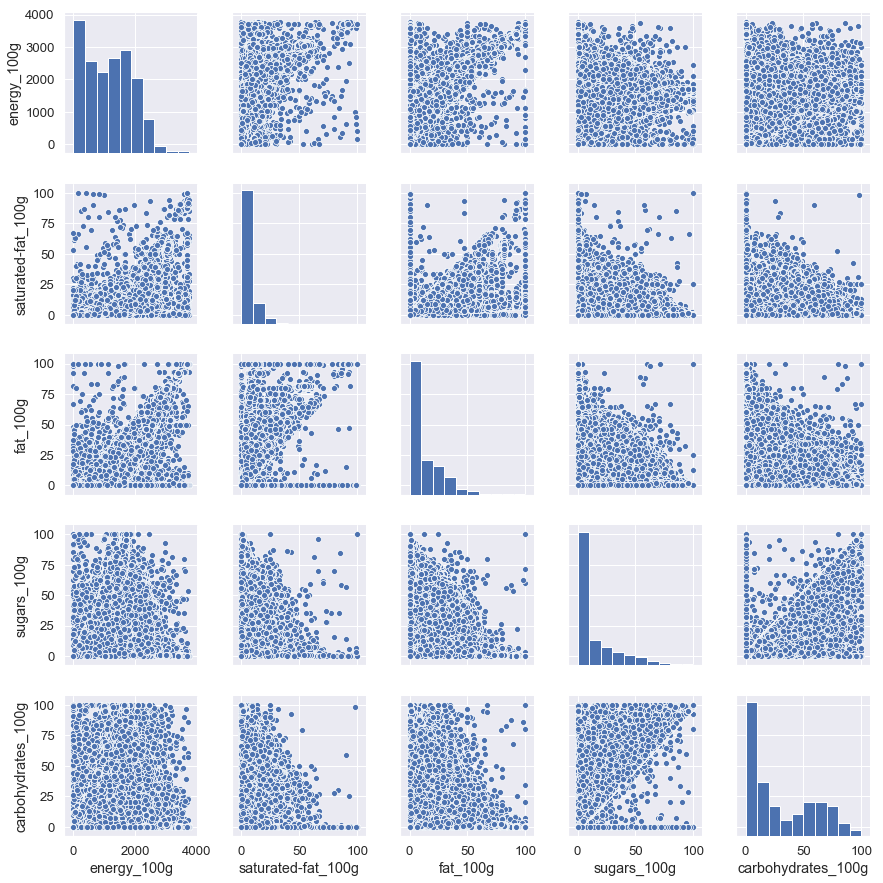

In [115]:
top_5 = num[['energy_100g',
            'saturated-fat_100g',                
            'fat_100g',                                
            'sugars_100g',                             
            'carbohydrates_100g' ]]
sns.pairplot(top_5)
plt.show()

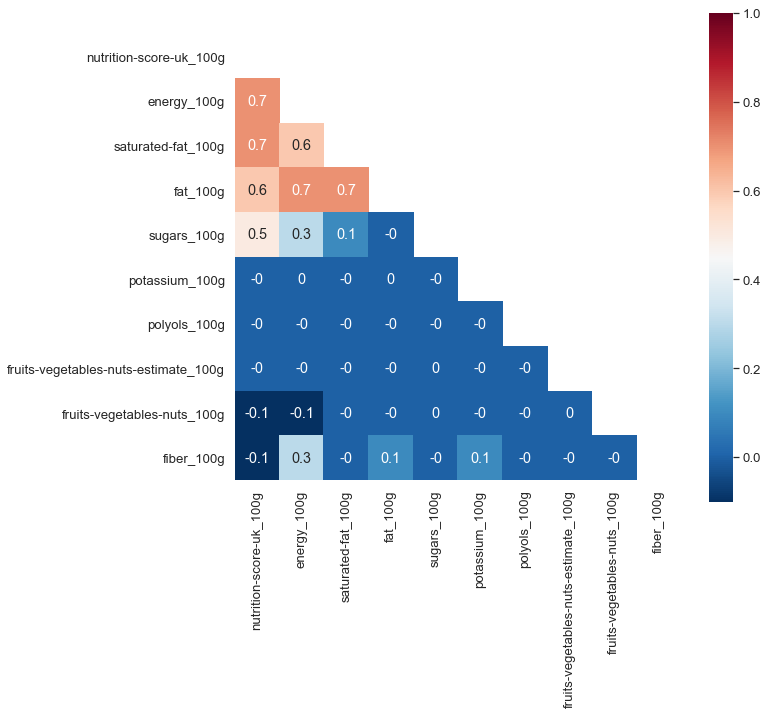

In [109]:
# Select only the top and bottom 5 variables
top_bot_5 = num[["nutrition-score-uk_100g", "energy_100g", "saturated-fat_100g", "fat_100g", "sugars_100g",
               "potassium_100g", "polyols_100g", "fruits-vegetables-nuts-estimate_100g", "fruits-vegetables-nuts_100g",
               "fiber_100g"]]

corr = top_bot_5.corr().round(1) # rounding at 1 decimal

# Create map
plt.figure(figsize=(10, 9))
# 
mask = np.zeros_like(corr) # create a matrix of zeros the size of the correlation matrix
mask[np.triu_indices_from(mask)] = True # Mask the upper half of the matrix

sns.set(font_scale=1.2)
with sns.axes_style("white"):
    sns.heatmap(corr,  annot = True ,vmax=1, cmap="RdBu_r",square=True, mask=mask)

So we can see that __energy__ is correlated with the score which is not surprising. Indeed, a food with a lot of calories will be considered as bad for your health. The same goes for __fat__ and __sugar__. I am surprised to see that salt is not in the top 5.

On the other hand, __fiber__, __fruits__ and __vegetables__ seem to me rather weakly inversely correlated, and therefore better for health. The relationship is on the other hand much weaker and this is logical. The unhealthy ingredient outweighs the healthy ingredient. If you eat a food with a lot of fiber but also a lot of calories, the food will be considered unhealthy despite the presence of fiber. 

Thank you very much for reading my report and data analysis. I hope you enjoyed it. I'm looking forward to get your feedback.